In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
def give_quarter_performance(Predictions,Labels,quarter):
    quarter = str(quarter)
    Q = Predictions[quarter]
    Q_labels = Labels[quarter]
    Q = Q.sort_values(ascending=False)
    Q_top_30 = Q[:30]
    
    top_30_labels = []

    for index in Q_top_30.index:
        row = Q_labels.loc[index]
        top_30_labels.append(row)
    
    labels_series = pd.Series(top_30_labels)
    final_df = pd.DataFrame({'Preds': Q_top_30.values,'Labels': labels_series.values},index=Q_top_30.index)
    
    return final_df

def quarter_performance(Quarter_result):    
    portfolio_start = 30
    portfolio_end = 0
    for value in Quarter_result['Labels'].values:
        portfolio_end = portfolio_end + 1 + value
    
    perfomance = ((portfolio_end-portfolio_start)/portfolio_start)*100
    return perfomance
        
def total_performance(num_quarters,Predictions,labels_df, model):
    total_returns = 100
    q_turnouts = [100]
    for quarter in range(num_quarters):
        Q_result = give_quarter_performance(Predictions,labels_df,quarter)
        Q_per = quarter_performance(Q_result)
        
        total_returns = total_returns * (1+(Q_per/100))
        print('Quarter :'+str(quarter+1)+'\t Result :' +str(Q_per)+' %')
        q_turnouts.append(total_returns)
    
    print('Compounded Result of',model,'model:'+str(total_returns-100)+str(' %'))
    plt.figure(figsize=(10,5))
    plt.plot(q_turnouts)
    plt.ylabel('Portfolio Value')
    plt.xlabel('Quarters')
    plt.title('Portfolio Performance of '+str(model)+' model')
    plt.show()

    

Quarter :1	 Result :7.766007097562901 %
Quarter :2	 Result :6.013627060671153 %
Quarter :3	 Result :4.991987461603328 %
Quarter :4	 Result :3.8072195517601064 %
Quarter :5	 Result :8.549411238578013 %
Quarter :6	 Result :-6.782398606249237 %
Quarter :7	 Result :-2.4836743701719994 %
Quarter :8	 Result :11.030961354651698 %
Compounded Result of Lasso model:36.41873745404155 %


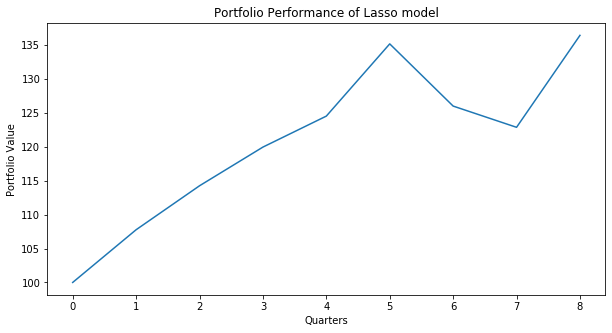

Quarter :1	 Result :8.875756690932093 %
Quarter :2	 Result :7.609781975821643 %
Quarter :3	 Result :5.603823678951763 %
Quarter :4	 Result :4.9336245581601075 %
Quarter :5	 Result :5.676702411381764 %
Quarter :6	 Result :-2.769552399488807 %
Quarter :7	 Result :0.9431876713871882 %
Quarter :8	 Result :9.073568670171829 %
Compounded Result of RF model:46.877520069497336 %


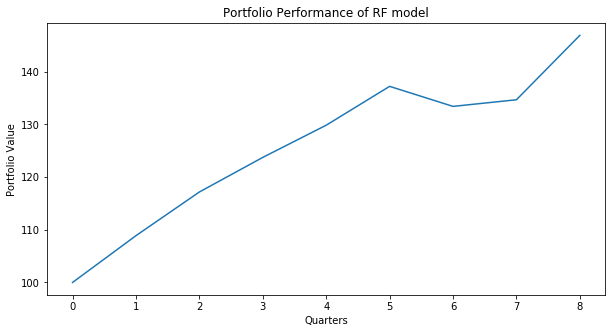

Quarter :1	 Result :7.60000517707501 %
Quarter :2	 Result :8.370452255033788 %
Quarter :3	 Result :4.733193066957142 %
Quarter :4	 Result :1.6865345729452843 %
Quarter :5	 Result :5.784948307237012 %
Quarter :6	 Result :-5.036566037791381 %
Quarter :7	 Result :-2.7959073204658225 %
Quarter :8	 Result :8.340760062226545 %
Compounded Result of Bagging model:31.379524941673168 %


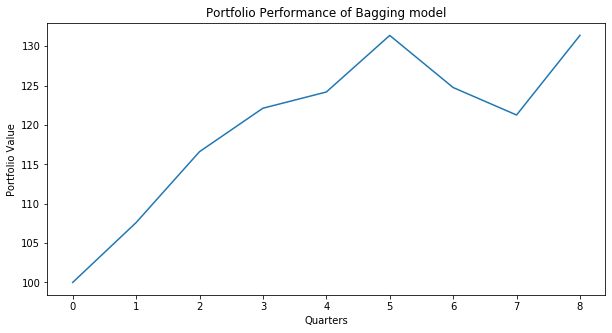

Quarter :1	 Result :7.562245639769524 %
Quarter :2	 Result :6.073424094431796 %
Quarter :3	 Result :6.403820629787566 %
Quarter :4	 Result :1.5901061859615242 %
Quarter :5	 Result :6.654146773953376 %
Quarter :6	 Result :-5.8277627506648475 %
Quarter :7	 Result :-3.5213932463231497 %
Quarter :8	 Result :7.58053401134499 %
Compounded Result of Elastic_Net model:28.570235186848038 %


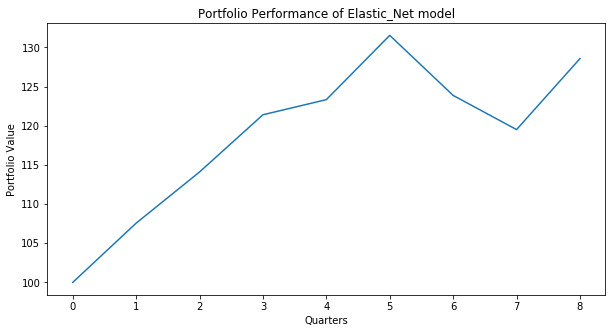

In [59]:
Models = ['Lasso','RF','Bagging','Elastic_Net']
Labels = pd.read_csv('./Labels_and_Preds/Labels.csv',delimiter =',',index_col = 'Unnamed: 0')

for model in Models:
    Preds = pd.read_csv('./Labels_and_Preds/Predictions_'+model+'.csv', delimiter = ',', index_col = 'Unnamed: 0')
    total_performance(8,Preds,Labels,model)

In [60]:
def aggregate(Models,num_quarters):
    model_dfs = []
    for model in Models:
        Preds = pd.read_csv('./Labels_and_Preds/Predictions_'+model+'.csv', delimiter = ',', index_col = 'Unnamed: 0')
        model_df = pd.DataFrame()
        for quarter in range(num_quarters):
            Q_portfolio = give_quarter_performance(Preds,Labels,quarter)
            temp_df = pd.DataFrame(Q_portfolio.index)
            model_df = pd.concat([model_df,temp_df], ignore_index= True, axis =1)

        model_dfs.append(model_df)
        
    return model_dfs

In [61]:
Q = aggregate(Models,8)

In [62]:
'''
0: Lasso
1: NN
2: RF
3: Elastic Net
4: Bagging
5: Ridge
'''

'\n0: Lasso\n1: NN\n2: RF\n3: Elastic Net\n4: Bagging\n5: Ridge\n'

In [63]:
import operator
import itertools

def bootstrap_aggregate(model_outputs):
    Overall_aggregate = []
    num_quarters = model_outputs[0].shape[1]
    for i in range(num_quarters):
        Quarter_aggregate = {}
        for j in range(len(model_outputs)):
            model_portfolio = model_outputs[j][i].values
            for value in model_portfolio:
                value = str(value)
                if value in Quarter_aggregate:
                    Quarter_aggregate[value]+=1
                else:
                    Quarter_aggregate[value] = 1
                    
        Quarter_aggregate_sorted = dict( sorted(Quarter_aggregate.items(), key=operator.itemgetter(1),reverse=True))
        Quarter_aggregate_top_30 = dict(itertools.islice(Quarter_aggregate_sorted.items(), 30))
        Quarter_aggregate_df = pd.DataFrame(list(Quarter_aggregate_top_30.items()))
        Overall_aggregate.append(Quarter_aggregate_df)

    return Overall_aggregate


In [64]:
Overall_bootstrap_agg = bootstrap_aggregate(Q)

In [65]:
def aggregated_performance_top_30(Overall_bootstrap,Labels):
    num_quarters = len(Overall_bootstrap)
    
    total_returns = 100
    q_pers = []
    for quarter in range(num_quarters):
        assets = Overall_bootstrap[quarter][0].values
        q_performance = 0
        asset_labels = Labels[str(quarter)]
        
        for asset in assets:
            asset_performance = asset_labels.loc[(asset)] 
            q_performance = q_performance + 1 + asset_performance
            q_per = ((q_performance-30)/30)*100
        
        total_returns = total_returns * (1+(q_per/100))
        
        print('Quarter :'+str(quarter+1)+'\t Result :' +str(q_per)+' %')
        q_pers.append(q_per)
        
    compounded_result = total_returns-100
    q_avg_return = pow(total_returns/100, 1/num_quarters) - 1
    CAGR = pow(total_returns/100, 1/(num_quarters/4)) - 1
    
    print('Compounded Result :'+str(compounded_result)+str(' %'))
    print('Quarterly Compounded Growth Rate :', q_avg_return*100, '%')
    print('Annual Compounded Growth Rate :', CAGR*100, '%')
    print('Sharpe Ratio :', pow(q_avg_return*100/np.std(q_pers),1/4))

In [66]:
aggregated_performance_top_30(Overall_bootstrap_agg,Labels)

Quarter :1	 Result :7.649802731656052 %
Quarter :2	 Result :6.691192372161557 %
Quarter :3	 Result :5.766623988713633 %
Quarter :4	 Result :4.499723001463837 %
Quarter :5	 Result :8.253159678666105 %
Quarter :6	 Result :-5.9292593959513225 %
Quarter :7	 Result :-1.6779717749348322 %
Quarter :8	 Result :8.381694019534459 %
Compounded Result :37.75503980425742 %
Quarterly Compounded Growth Rate : 4.085069629299887 %
Annual Compounded Growth Rate : 17.369092952215247 %
Sharpe Ratio : 0.955769509801188


In [22]:
# thresholding done
# binarisation done
# denoising - local means, NLM, gaussian - done
# dilation - done
# erosion - done
# segmentation 
# brightness 
# contrast 
# histogram equalization - done
# linear stretching 